# Introduction

In this project, I aim to classify tweets as disaster-related or not using natural language processing (NLP) techniques, for a Kaggle competition. I will preprocess the text data by applying common techniques such as lowercasing, removing stopwords, and lemmatization to improve model performance. To capture the semantic meaning of the text, I explored two feature engineering approaches: a document-term matrix (DTM) for traditional models like Logistic Regression and Random Forest, and Word2Vec embeddings for deep learning models like RNN and LSTM. This dual approach allows comparison between the effectiveness of both classical machine learning and modern neural networks in text classification and gave a benchmark for evaluating the success of my neural network model. Furthermore, I perform hyperparameter tuning and look to improve the deep learning model by iterating over different architectures.


The Kaggle NLP Disaster Tweets dataset contains 10,000 tweets that are classified as either related to real disasters or not. Each tweet is labeled with a binary target, where 1 indicates a disaster-related tweet and 0 represents a non-disaster tweet. The dataset includes features such as the tweet's text, location, and keyword.

In [177]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Data

Since we only need to focus on text and target, we drop the ID, keyword and location columns.
Inspecting the data, there are several potential issues that arise in the text fields which influenced the subseqent decisions. 
I include the following functions for text preprocessing:
* Replacing any emojis
* Lowercasing text
* Replacing abbreviations
* Removing stopwords 
* Lemmatization
* Removing HTML tags
* Removing URL links
* Removing special characters



In [178]:
import spacy
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji


In [179]:
train=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [180]:
print('length of data:',len(train))
train.isnull().sum()

length of data: 7613


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [181]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [182]:
train=train.drop(['id','keyword','location'],axis=1)
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [183]:

def lowercase(text):
    return text.lower()

replacements = {
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "i'll": "i will",
    "you'll": "you will",
    "we'll": "we will",
    "they'll": "they will",
    "he'd": "he would",
    "she'd": "she would",
    "it'd": "it would",
    "i'd": "i would",
    "you'd": "you would",
    "we'd": "we would",
    "they'd": "they would",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "won't": "will not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not",
    "aren't": "are not",
    "isn't": "is not",
    "wasn't": "was not",
    "weren't": "were not",
    
}

def replace_emojis(text):
    return emoji.demojize(text, delimiters=(":", ":"))


def replace_abb(text):
    
    for short_form, full_form in replacements.items():
        text = text.replace(short_form, full_form)
    return text


nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    doc = nlp(text)
    filtered_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return filtered_text

def remove_html_tags(input_text):
    soup = BeautifulSoup(input_text, 'html.parser')
    text_without_tags = soup.get_text()
    return text_without_tags

def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

def remove_special_characters(text):
    pattern = r'[=!#%@$^&*()_+{}\[\]:;"\'<>,.?/|\\\-]|[0-9]'
    
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

In [184]:
train['filtered_text']=train['text'].apply(lowercase)
train['filtered_text'] = train['filtered_text'].apply(replace_abb)
train['filtered_text'] = train['filtered_text'].apply(replace_emojis)
train['filtered_text'] = train['filtered_text'].apply(remove_stopwords)
train['filtered_text'] = train['filtered_text'].apply(remove_html_tags)
train['filtered_text'] = train['filtered_text'].apply(remove_url)
train['filtered_text'] = train['filtered_text'].apply(remove_special_characters)

/tmp/ipykernel_32/2898329248.py:64: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(input_text, 'html.parser')


In [185]:
train.head()

,text,target,filtered_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...


# EDA

* Class distribution - checking whether the data set is imbalanced
* Tweet length comparison - checking whether disaster tweets are a notably different length to non-distaster ones
* Word frequency analysis - using word clouds to clean up irrelevant words that appear with both labels

In [186]:
combined_text_pos = ' '.join(train[train['target']==1]['filtered_text'])
combined_text_neg = ' '.join(train[train['target']==0]['filtered_text'])

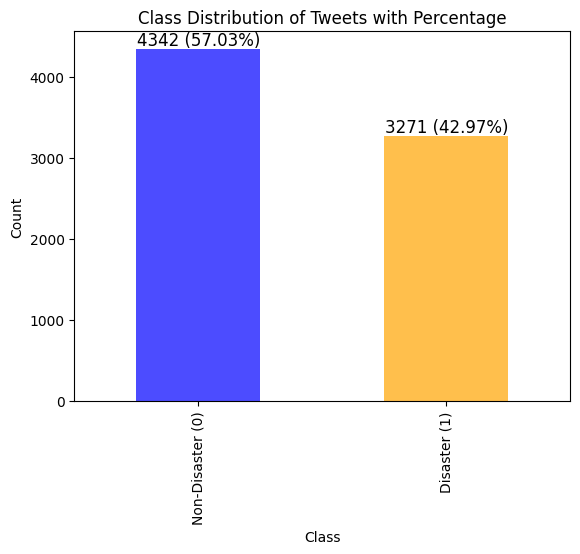

In [187]:
# Class distribution
class_counts = train['target'].value_counts()
class_percentages = train['target'].value_counts(normalize=True) * 100

ax = class_counts.plot(kind='bar', alpha=0.7, color=['blue', 'orange'], title='Disaster vs Non-Disaster Tweet Distribution')

for i, count in enumerate(class_counts):
    percentage = class_percentages[i]
    ax.text(i, count + 50, f'{count} ({percentage:.2f}%)', ha='center', fontsize=12)

plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Disaster (0)', 'Disaster (1)'])
plt.title('Class Distribution of Tweets with Percentage')
plt.show()


The dataset is fairly balanced, with more non-disaster tweets. This slight imbalance could have an impact on the models and potentially could be taken into account at later iterations.

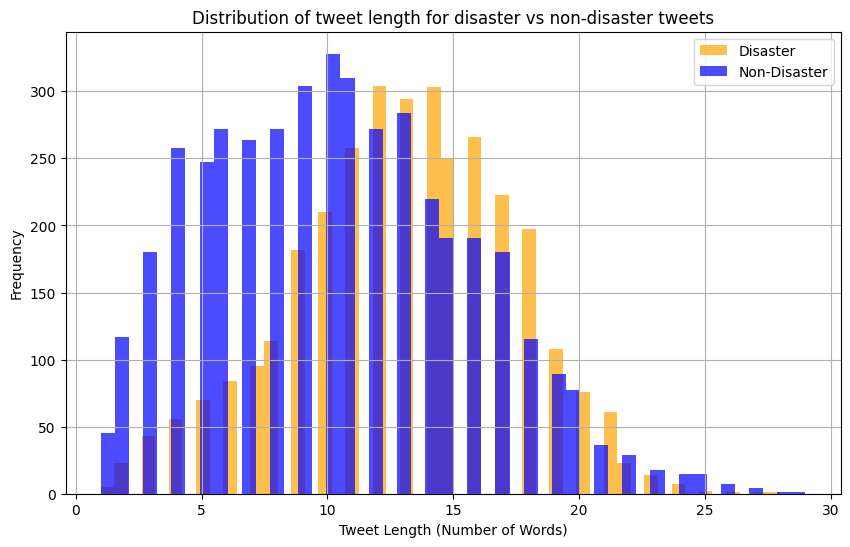

In [188]:
# Tweet length investigation

train['tweet_length'] = train['filtered_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))

train[train['target'] == 1]['tweet_length'].hist(alpha=0.7, label='Disaster', bins=50, color='orange')
train[train['target'] == 0]['tweet_length'].hist(alpha=0.7, label='Non-Disaster', bins=50, color='blue')

plt.xlabel('Tweet Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of tweet length for disaster vs non-disaster tweets')
plt.legend()
plt.show()


We see there is no notable variation in tweet length to consider, though disaster tweets are a fraction longer, there is still a lot of overlap so this shouldn't affect the model. 

In [189]:
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(combined_text_pos)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(combined_text_neg)

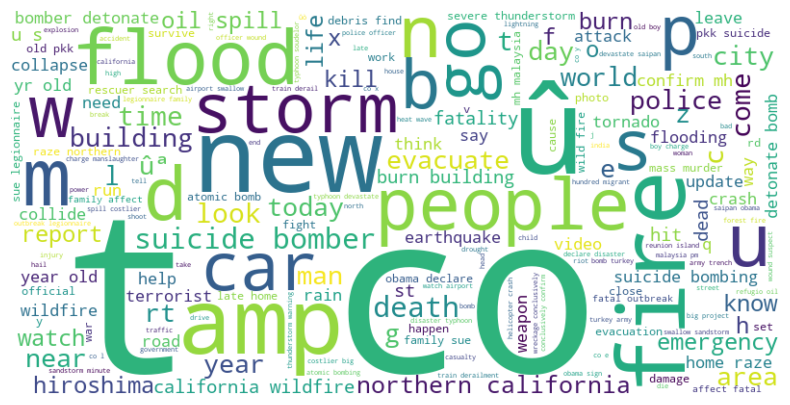

In [190]:
#Actual disaster wordcloud

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off') 
plt.show()

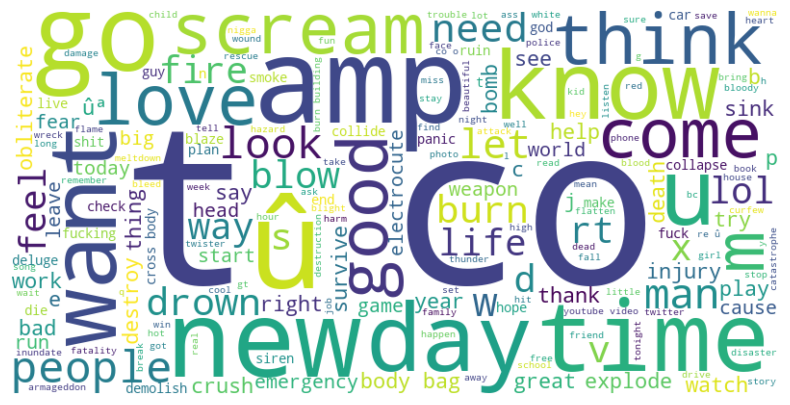

In [191]:
#False disaster wordcloud

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.show()

The above word clouds indicate that we can remove the following:
* Common words: co, time, new, think, amp
* Individual letters a-z
* u with circumflex

In [192]:
#Removing common words

import re

def remove_special_characters(text):
    words_to_remove = ['co', 'time', 'new', 'think', 'amp']
    letters_to_remove = r'\b[a-z]\b'  
    u_circumflex = '\u00FB'  

    for word in words_to_remove:
        text = text.replace(word, '')

    text = re.sub(letters_to_remove, '', text, flags=re.IGNORECASE)
    text = text.replace(u_circumflex, '')

    return text

train['filtered_text'] = train['filtered_text'].apply(remove_special_characters)

In [193]:
train.head()

,text,target,filtered_text,tweet_length
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,5
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...,11
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation or...,6
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...,9


In [194]:
combined_text_pos_2 = ' '.join(train[train['target']==1]['filtered_text'])
wordcloud_pos_2 = WordCloud(width=800, height=400, background_color='white').generate(combined_text_pos_2)

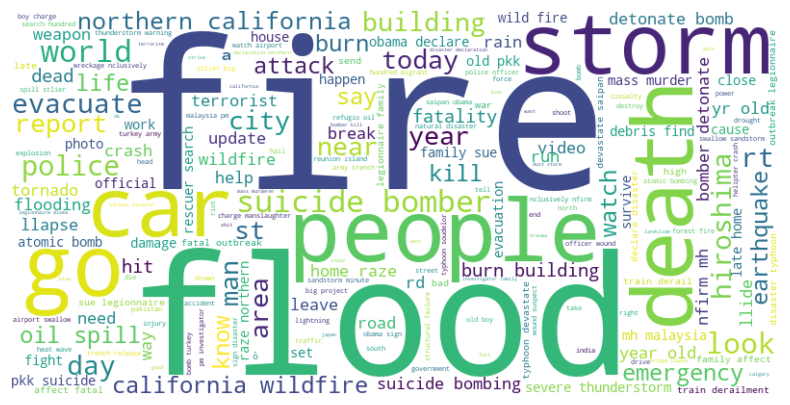

In [195]:
# Updated, actual disaster wordcloud

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos_2, interpolation='bilinear')
plt.axis('off')
plt.show()

The above wordcloud now shows a better representation of the disaster tweet relevant text which will be useful in training models. 

# Model training

EDA revealed a fairly even class distribution, with no significant differences in tweet length between disaster and non-disaster tweets. We further cleaned the dataset based on insights from the word cloud, improving text preprocessing for the next steps. Given the results of the EDA, I look to continue with a dual method, which helps compare classical machine learning with modern neural networks for text classification tasks.

Two feature engineering approaches will be used to train models for disaster tweet classification.

First, a Document-Term Matrix (DTM) to capture word frequency features, followed by Logistic Regression and Random Forest models. Logistic Regression is a strong baseline for text classification, and Random Forest adds the benefit of potentially improving performance through ensemble learning.

Second, Word2Vec embeddings to capture the semantic relationships between words and apply RNN/LSTM models. RNNs and LSTMs are well-suited for sequential data like text, allowing the models to learn contextual information across word sequences.

In [196]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [197]:
# Splitting dataset into test and train

xtrain,xtest,ytrain,ytest=train_test_split(train['filtered_text'], train['target'], stratify=train['target'], test_size=0.3, random_state=42)

# 1. Document-term matrix 

The DTM represents the frequency of words across the dataset, where each row corresponds to a tweet and each column represents a unique word. The value in each cell reflects how many times a particular word appears in a specific tweet. This matrix-based approach allows us to transform text into numerical data, which can be easily used by machine learning models.

In [198]:
# Create Document Term Matrix

vectorizer = CountVectorizer()
xtrain = vectorizer.fit_transform(xtrain)
xtest = vectorizer.transform(xtest)

In [199]:
#Prediction using logistic regression

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(xtrain, ytrain)

# Predict sentiment on the test set

predictions_lr = logreg.predict(xtest)

print("Accuracy of Logistic Regression:", accuracy_score(ytest, predictions_lr))

Accuracy of Logistic Regression: 0.7955341506129597


In [200]:
# Prediction using random forest classifier

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42).fit(xtrain, ytrain)

# Predict sentiment on the test set

predictions_rf = rf.predict(xtest)

# Calculate evaluation metrics

print("Accuracy of Random Forest Classifier:", accuracy_score(ytest, predictions_rf))

Accuracy of Random Forest Classifier: 0.7902802101576182


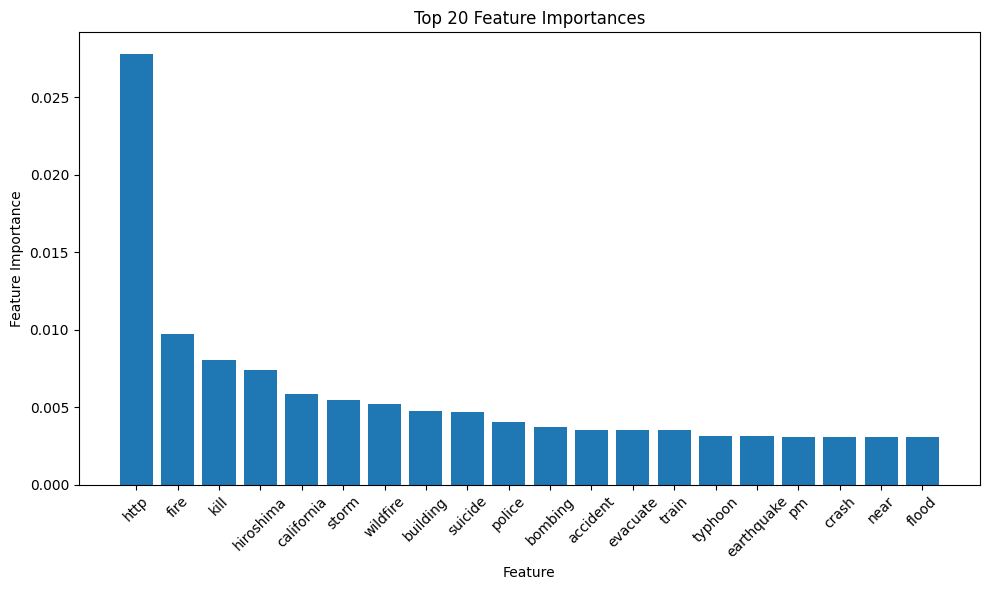

In [201]:
# Feature importance of Random Forest

feature_importances = rf.feature_importances_


feature_names = vectorizer.get_feature_names_out()
indices = np.argsort(feature_importances)[::-1]

top_features_count = 20
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(top_features_count), feature_importances[indices[:top_features_count]], align="center")
plt.xticks(range(top_features_count), [feature_names[i] for i in indices[:top_features_count]], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.tight_layout()
plt.show()

# 2. Word2Vec

Word2Vec transforms words into  numerical vectors that capture the semantic meaning of words based on their context. These word embeddings allow the model to understand relationships between words beyond simple frequency counts. Once converted into vectors, the text can be used as input for RNN or LSTM models, which capture sequential dependencies and contextual information in the text for better classification. The expectation was that this performs better than the earlier model. 

In [202]:
# For Word2Vec

from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

In [203]:
# Tokenise and apply Word2Vec model

train['filtered_text_token'] = train['filtered_text'].apply(word_tokenize)
w2v_model = Word2Vec(sentences=train['filtered_text_token'], vector_size=50, window=1, min_count=5, sg=0, seed=42) #CBOW variation

In [204]:
train.head()

,text,target,filtered_text,tweet_length,filtered_text_token
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,5,"[deed, reason, earthquake, allah, forgive]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...,11,"[resident, ask, shelter, place, notify, office..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation or...,6,"[people, receive, wildfire, evacuation, order,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...,9,"[got, send, photo, ruby, alaska, smoke, wildfi..."


In [205]:
# Determine our max length pad sequence
print('max length of filtered text:',max(train['filtered_text_token'].apply(len)))

max length of filtered text: 21


In [206]:
xtrain,xtest,ytrain,ytest=train_test_split(train['filtered_text'], train['target'], stratify=train['target'], test_size=0.3, random_state=42)

In [207]:
# Convert words to indices using the Word2Vec model vocabulary

word_vectors = w2v_model.wv
tokenizer = Tokenizer()
tokenizer.word_index = {word: idx for idx, word in enumerate(word_vectors.index_to_key)}

# Convert text to sequences of word indices

sequences_train = tokenizer.texts_to_sequences(xtrain)
sequences_test = tokenizer.texts_to_sequences(xtest)

# Pad sequences for consistent input shape

max_sequence_length = 21 
xtrain = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
xtest = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, w2v_model.vector_size))
for word, idx in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[idx] = word_vectors[word]

# Build LSTM model with Word2Vec embeddings

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=w2v_model.vector_size,
                    weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(LSTM(units=128, dropout=0.2,return_sequences=True))
model.add(LSTM(units=128, dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))  # For binary classification; use softmax for multi-class

# Compile the model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model

history = model.fit(xtrain, ytrain, epochs=20, batch_size=16, validation_data=(xtest, ytest))

# Evaluate the model

loss, accuracy = model.evaluate(xtest, ytest)
print(f'Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
334/334 [==============================] - 8s 12ms/step - loss: 0.6820 - accuracy: 0.5705 - val_loss: 0.6586 - val_accuracy: 0.6116
Epoch 2/20
334/334 [==============================] - 3s 10ms/step - loss: 0.6711 - accuracy: 0.5830 - val_loss: 0.6801 - val_accuracy: 0.5705
Epoch 3/20
334/334 [==============================] - 3s 10ms/step - loss: 0.6631 - accuracy: 0.5965 - val_loss: 0.6607 - val_accuracy: 0.6025
Epoch 4/20
334/334 [==============================] - 3s 10ms/step - loss: 0.6540 - accuracy: 0.6078 - val_loss: 0.6506 - val_accuracy: 0.6200
Epoch 5/20
334/334 [==============================] - 3s 9ms/step - loss: 0.6493 - accuracy: 0.6181 - val_loss: 0.6681 - val_accuracy: 0.5915
Epoch 6/20
334/334 [==============================] - 3s 10ms/step - loss: 0.6483 - accuracy: 0.6183 - val_loss: 0.6496 - val_accuracy: 0.6226
Epoch 7/20
334/334 [==============================] - 3s 10ms/step - loss: 0.6489 - accuracy: 0.6224 - val_loss: 0.6479 - val_accuracy: 0.6200


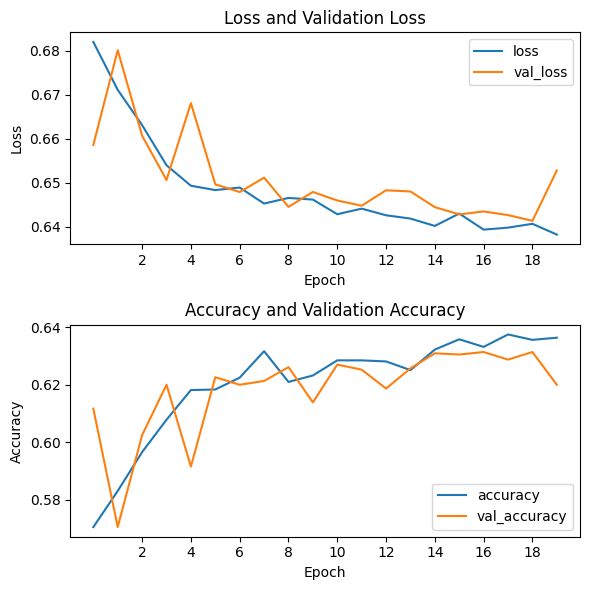

In [208]:
# Plot out accuracy and loss curve

history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

x_ticks = np.arange(2, len(history_df) + 1, 2)
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_ticks)


# Plot loss and val_loss 

history_df.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title('Loss and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

x_ticks = np.arange(2, len(history_df) + 1, 2)
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels(x_ticks)

# Plot accuracy and val_accuracy 

history_df.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title('Accuracy and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

# Adjust layout to prevent overlapping titles and labels

plt.tight_layout()

# Show the plots

plt.show()

The model achieves an accuracy of 68.30%, with both training and validation loss decreasing over time, though the validation loss fluctuates more, indicating mild overfitting. The accuracy steadily improves but plateaus around 64%, suggesting the model is only moderately effective. The fluctuations in both loss and accuracy suggest potential benefits from regularization techniques like dropout or L2 regularization to improve stability and generalization. 

The next step will be to do some hyperparameter tuning to try and improve the result. 

Key Hyperparameters to Tune:
* Number of LSTM units (units)
* Dropout rate (dropout)
* Batch size (batch_size)
* Learning rate (via optimizer)

LSTM unit tuning, tryig 128 and 256

* Accuracy: 68.65% for LSTM: 128
* Accuracy: 68.61% for LSTM: 256

Given this we will move forward with LSTM 128


Next we look at adjusting the drop out, trying 0.3 and 0.5 


* Accuracy: 68.61% for drop out: 0.3
* Accuracy: 68.48% for drop out: 0.5

Since both accuracies are a fraction lower, we move forward with the original 0.2.

Next, it's the batch_size - trying a batch of 32
* Accuracy: 68.61% for batch size: 32

Therefore we move forward with the original size 16


Finally, we look at a different range of epochs - testing 10 and 30.
* Accuracy: 61.32% for epochs: 10
* Accuracy: 68.08% for epochs: 30

Therefore we move forward with 20 epochs. 

## Model summary table

In [209]:
# Fixed version to display the table properly
import pandas as pd

# Create a summary table for logistic regression, random forest, and LSTM results
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'LSTM (Units=128) (Best)', 'LSTM (Units=256)', 
              'LSTM (Dropout=0.3)', 'LSTM (Dropout=0.5)', 
              'LSTM (Batch Size=32)', 'LSTM (Epochs=10)', 'LSTM (Epochs=30)'],
    'Accuracy (%)': [79.6, 79.0,
                 68.65, 68.61, 
                 68.61, 68.48, 
                 68.61, 61.32, 68.08],
    'Details': ['-', '-', 'Best hyperparameter combination', 
                'Tuned LSTM units', 'Tuned Dropout rate', 
                'Tuned Dropout rate', 'Tuned Batch Size', 'Tuned Epochs', 'Tuned Epochs']
}

# Create a DataFrame
results_df = pd.DataFrame(data)

# Display the results summary table
print("Results Summary:")
print(results_df)


Results Summary:
                     Model  Accuracy (%)                          Details
0      Logistic Regression         79.60                                -
1            Random Forest         79.00                                -
2  LSTM (Units=128) (Best)         68.65  Best hyperparameter combination
3         LSTM (Units=256)         68.61                 Tuned LSTM units
4       LSTM (Dropout=0.3)         68.61               Tuned Dropout rate
5       LSTM (Dropout=0.5)         68.48               Tuned Dropout rate
6     LSTM (Batch Size=32)         68.61                 Tuned Batch Size
7         LSTM (Epochs=10)         61.32                     Tuned Epochs
8         LSTM (Epochs=30)         68.08                     Tuned Epochs


## Analysis

This project compared the performance of Logistic Regression, Random Forest, and an LSTM model with Word2Vec embeddings. Logistic Regression achieved the highest accuracy at 79.6%, slightly outperforming Random Forest at 79%. The LSTM model, despite hyperparameter tuning, achieved a best accuracy of 68.65%. The hyperparameter optimization focused on LSTM units, dropout rates, batch size, and epochs. Adjusting the number of units yielded a small improvement, with 128 units outperforming 256. Increasing dropout to 0.5 or batch size to 32 didn't significantly improve accuracy, suggesting that the model's regularisation and capacity were sufficient with the original settings. Further, reducing epochs to 10 caused underfitting, but 30 epochs did not outperform 20 epochs. Troubleshooting involved tuning these key parameters and evaluating the model's performance iteratively.


## Conclusion

Logistic Regression proved to be the most effective model, achieving 79.6% accuracy, followed closely by Random Forest. The LSTM model's best performance was lower at 68.65%, even after tuning. This suggests that simpler models like Logistic Regression are better suited for this dataset, likely due to the small size and lack of significant sequential dependencies in tweets. One takeaway is that hyperparameter tuning had a limited impact, indicating that the LSTM architecture may not be the best fit here. Future improvements could involve experimenting with more complex architectures like transformers or adding more features to the dataset to enhance its performance.



## Test data preprocessing and submission

In [210]:
test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test.head()


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [211]:
Id=test['id']
test=test.drop(['id','keyword','location'],axis=1)


In [212]:
test['filtered_text'] = test['text'].apply(lowercase)
test['filtered_text'] = test['filtered_text'].apply(replace_abb)
test['filtered_text'] = test['filtered_text'].apply(replace_emojis)
test['filtered_text'] = test['filtered_text'].apply(remove_stopwords)
test['filtered_text'] = test['filtered_text'].apply(remove_html_tags)
test['filtered_text'] = test['filtered_text'].apply(remove_url)
test['filtered_text'] = test['filtered_text'].apply(remove_special_characters)

test = vectorizer.transform(test['filtered_text'])


/tmp/ipykernel_32/2898329248.py:64: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(input_text, 'html.parser')


In [213]:
#Final submission ( logistic regression ) 

ypred=logreg.predict(test)
final = np.round(ypred)
output = pd.DataFrame({'id': Id,'target': final.astype(int) })
output

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [214]:
output.to_csv('submissiontwwet.csv', index=False)